# CIFAR10 Image Classification

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. 

## Imports

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'cifar10')
if not results_path.exists():
    results_path.mkdir()

## Load CIFAR-10 Data

CIFAR10 can also be downloaded from keras, and we similarly rescale the pixel values and one-hot encode the ten class labels. 

In [5]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


### Visualize the First 30 Training Images

In [6]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [7]:
num_classes = len(cifar10_labels)

In [8]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

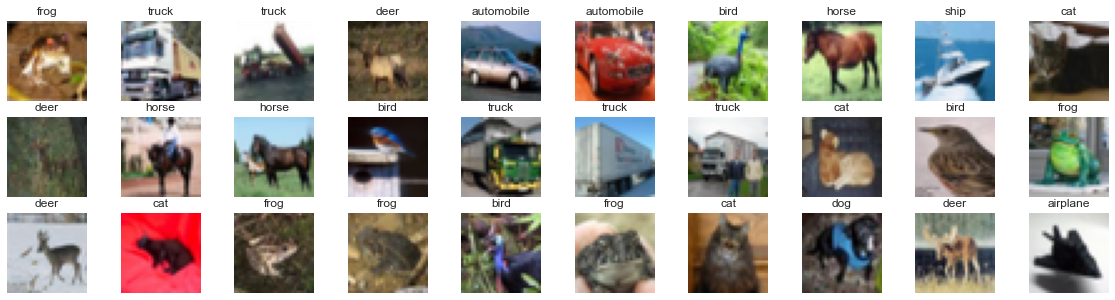

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

### Rescale the Images

In [10]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Train-Test split

In [11]:
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [12]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## Feedforward Neural Network

We first train a two-layer feedforward network on 50,000 training samples for training for 20 epochs to achieve a test accuracy of 44.22%. We also experiment with a three-layer convolutional net with 500K parameters for 67.07% test accuracy.

### Model Architecture 

In [14]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [15]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
droput_1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
______________________________________________

### Compile the Model 

In [16]:
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [17]:
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()

In [18]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [19]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'mlp',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model 

In [21]:
batch_size = 32
epochs = 100

In [22]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=1,
                      shuffle=True)

Epoch 1/100
1407/1407 [==============================] - 10s 6ms/step - loss: 2.1507 - accuracy: 0.2271 - val_loss: 1.8939 - val_accuracy: 0.3018

Epoch 00001: val_accuracy improved from -inf to 0.30180, saving model to results/cifar10\mlp.weights.best.hdf5
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8866 - accuracy: 0.3037 - val_loss: 1.7637 - val_accuracy: 0.3668

Epoch 00002: val_accuracy improved from 0.30180 to 0.36680, saving model to results/cifar10\mlp.weights.best.hdf5
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8313 - accuracy: 0.3279 - val_loss: 1.7631 - val_accuracy: 0.3610

Epoch 00003: val_accuracy did not improve from 0.36680
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7980 - accuracy: 0.3408 - val_loss: 1.7069 - val_accuracy: 0.3914

Epoch 00004: val_accuracy improved from 0.36680 to 0.39140, saving model to results/cifar10\mlp.weights.best.hdf5
Epoch 5/100
1407/1407

1407/1407 [==============================] - 8s 6ms/step - loss: 1.6058 - accuracy: 0.4199 - val_loss: 1.6042 - val_accuracy: 0.4346

Epoch 00038: val_accuracy did not improve from 0.44880
Epoch 39/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6051 - accuracy: 0.4219 - val_loss: 1.5691 - val_accuracy: 0.4440

Epoch 00039: val_accuracy did not improve from 0.44880
Epoch 40/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5905 - accuracy: 0.4223 - val_loss: 1.5690 - val_accuracy: 0.4498

Epoch 00040: val_accuracy improved from 0.44880 to 0.44980, saving model to results/cifar10\mlp.weights.best.hdf5
Epoch 41/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5952 - accuracy: 0.4225 - val_loss: 1.5917 - val_accuracy: 0.4430

Epoch 00041: val_accuracy did not improve from 0.44980
Epoch 42/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6095 - accuracy: 0.4208 - val_loss: 1.5762 - val_accuracy: 0.4438


### Plot CV Results

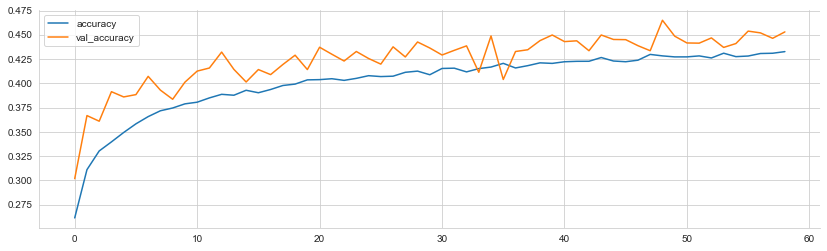

In [23]:
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

### Load best model

In [24]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [25]:
# evaluate and print test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 45.72%


## Convolutional Neural Network

In [26]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [27]:
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 32, 32, 16)        208       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 16, 16, 32)        2080      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 8, 8, 64)          8256      
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 4, 4, 64)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 4, 4, 64)          0

### Compile the Model

In [29]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [30]:
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()

In [31]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [32]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [33]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model

In [34]:
batch_size = 32
epochs = 100

In [35]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2,
                      shuffle=True)

Epoch 1/100
1407/1407 - 16s - loss: 1.5379 - accuracy: 0.4412 - val_loss: 1.2054 - val_accuracy: 0.5824

Epoch 00001: val_accuracy improved from -inf to 0.58240, saving model to results/cifar10\cnn.weights.best.hdf5
Epoch 2/100
1407/1407 - 11s - loss: 1.2120 - accuracy: 0.5664 - val_loss: 1.0590 - val_accuracy: 0.6240

Epoch 00002: val_accuracy improved from 0.58240 to 0.62400, saving model to results/cifar10\cnn.weights.best.hdf5
Epoch 3/100
1407/1407 - 10s - loss: 1.0917 - accuracy: 0.6113 - val_loss: 1.0163 - val_accuracy: 0.6334

Epoch 00003: val_accuracy improved from 0.62400 to 0.63340, saving model to results/cifar10\cnn.weights.best.hdf5
Epoch 4/100
1407/1407 - 11s - loss: 1.0146 - accuracy: 0.6412 - val_loss: 0.9298 - val_accuracy: 0.6832

Epoch 00004: val_accuracy improved from 0.63340 to 0.68320, saving model to results/cifar10\cnn.weights.best.hdf5
Epoch 5/100
1407/1407 - 11s - loss: 0.9549 - accuracy: 0.6609 - val_loss: 0.8756 - val_accuracy: 0.6962

Epoch 00005: val_accur

### Plot CV Results

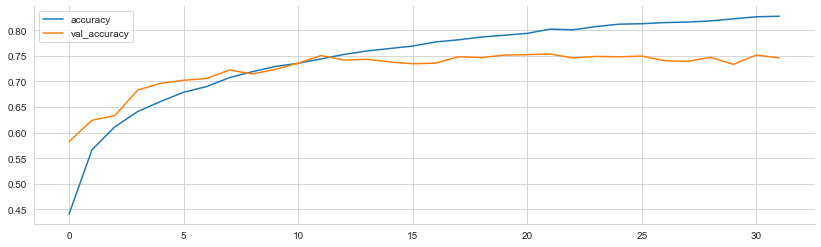

In [36]:
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

### Load best model

In [37]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [38]:
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 75.37%


### Evaluate Predictions

In [39]:
y_hat = cnn.predict(X_test)

C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\PC\anaconda3\envs\tensorflow_env\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0, flags=flags)


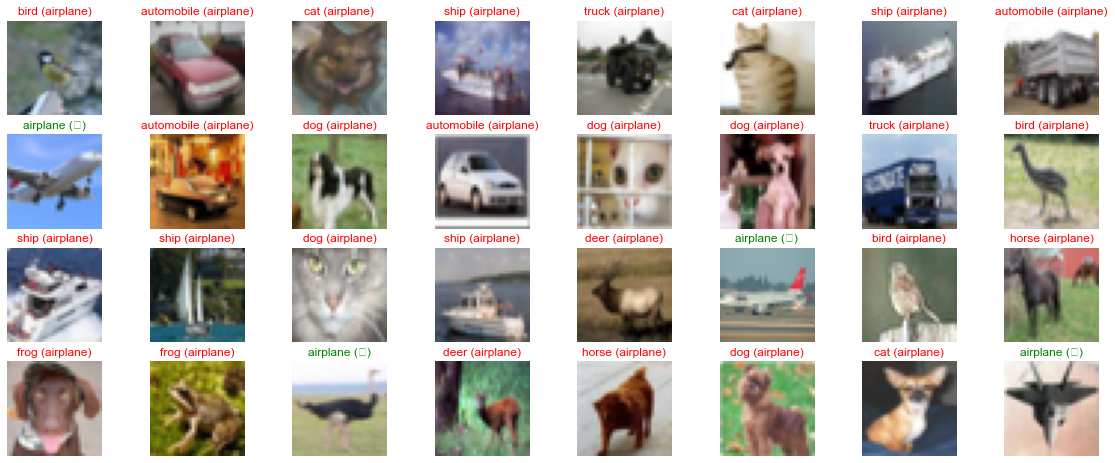

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx],
                                      cifar10_labels[true_idx]),
                     color='red')

## CNN with Image Augmentation

A common trick to enhance performance is to artificially increase the size of the training set by creating synthetic data. This involves randomly shifting or horizontally flipping the image, or introducing noise into the image.

### Create and configure augmented image generator

Keras includes an ImageDataGenerator for this purpose that we can configure and fit to the training data as follows:

In [41]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [42]:
# fit augmented image generator on data
datagen.fit(X_train)

### Visualize subset of training data

The result shows how the augmented images have been altered in various ways as expected:

In [43]:
n_images = 6
x_train_subset = X_train[:n_images]

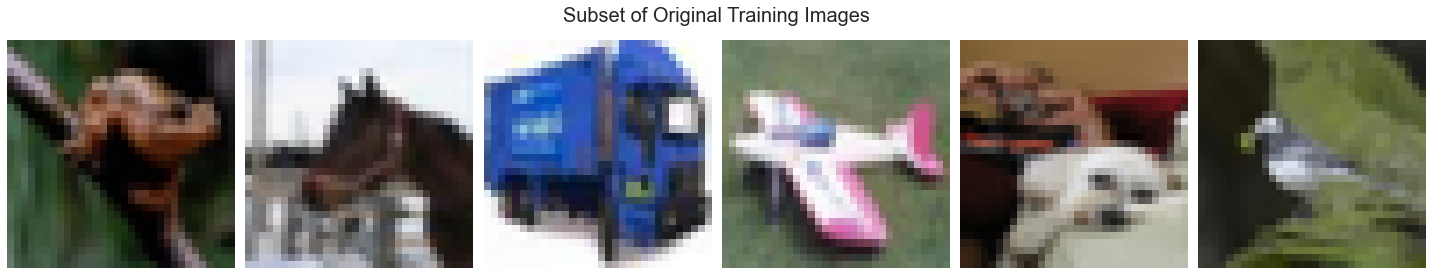

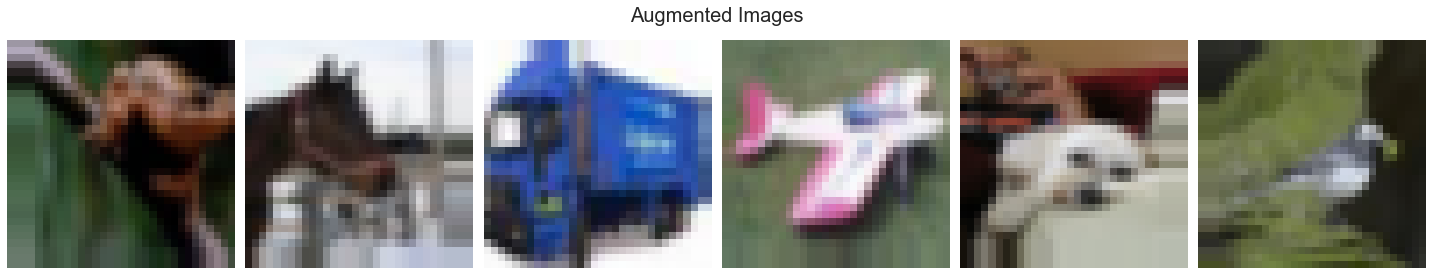

In [44]:
# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'original_images')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images,
                            shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'augmented_images')

### Define Callbacks

In [45]:
K.clear_session()

In [46]:
cnn_aug_path = (results_path / 'augmented.cnn.weights.best.hdf5').as_posix()

In [47]:
checkpointer = ModelCheckpoint(filepath=cnn_aug_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [48]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn_aug',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [49]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

### Train Augmented Images

In [50]:
batch_size = 32
epochs = 100

In [51]:
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2)

Epoch 1/100
1406/1406 - 17s - loss: 0.9831 - accuracy: 0.6586 - val_loss: 0.7672 - val_accuracy: 0.7370

Epoch 00001: val_accuracy improved from -inf to 0.73700, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
Epoch 2/100
1406/1406 - 15s - loss: 0.9491 - accuracy: 0.6675 - val_loss: 0.7818 - val_accuracy: 0.7390

Epoch 00002: val_accuracy improved from 0.73700 to 0.73900, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
Epoch 3/100
1406/1406 - 15s - loss: 0.9267 - accuracy: 0.6733 - val_loss: 0.7464 - val_accuracy: 0.7488

Epoch 00003: val_accuracy improved from 0.73900 to 0.74880, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
Epoch 4/100
1406/1406 - 15s - loss: 0.9212 - accuracy: 0.6783 - val_loss: 0.7827 - val_accuracy: 0.7328

Epoch 00004: val_accuracy did not improve from 0.74880
Epoch 5/100
1406/1406 - 15s - loss: 0.8997 - accuracy: 0.6815 - val_loss: 0.7662 - val_accuracy: 0.7370

Epoch 00005: val_accuracy did not improve from 0.74


Epoch 00047: val_accuracy did not improve from 0.78860
Epoch 48/100
1406/1406 - 18s - loss: 0.7552 - accuracy: 0.7371 - val_loss: 0.6502 - val_accuracy: 0.7806

Epoch 00048: val_accuracy did not improve from 0.78860
Epoch 49/100
1406/1406 - 18s - loss: 0.7531 - accuracy: 0.7359 - val_loss: 0.6209 - val_accuracy: 0.7962

Epoch 00049: val_accuracy improved from 0.78860 to 0.79620, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
Epoch 50/100
1406/1406 - 18s - loss: 0.7476 - accuracy: 0.7394 - val_loss: 0.6171 - val_accuracy: 0.7980

Epoch 00050: val_accuracy improved from 0.79620 to 0.79800, saving model to results/cifar10\augmented.cnn.weights.best.hdf5
Epoch 51/100
1406/1406 - 18s - loss: 0.7494 - accuracy: 0.7373 - val_loss: 0.6888 - val_accuracy: 0.7674

Epoch 00051: val_accuracy did not improve from 0.79800
Epoch 52/100
1406/1406 - 17s - loss: 0.7482 - accuracy: 0.7366 - val_loss: 0.6313 - val_accuracy: 0.7886

Epoch 00052: val_accuracy did not improve from 0.79800
E

### Plot CV Result

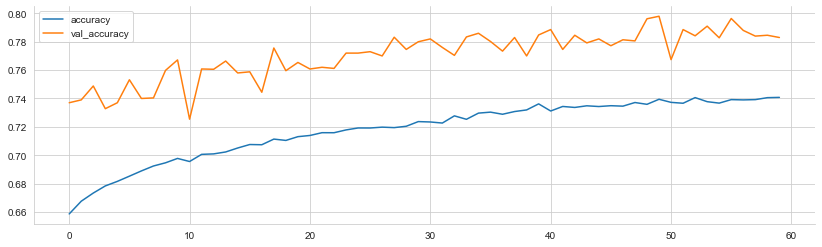

In [52]:
pd.DataFrame(cnn_aug_history.history)[['accuracy',
                                       'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

### Load best model

In [53]:
cnn.load_weights(cnn_aug_path)

### Test set accuracy

The test accuracy for the three-layer CNN improves markedly to 74.79% after training on the larger, augmented data.

In [54]:
cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

Test Accuracy: 78.05%


## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [55]:
K.clear_session()

In [56]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [57]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 16, 16, 96)        2688      
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 8, 8, 96)          0         
_________________________________________________________________
NORM_1 (BatchNormalization)  (None, 8, 8, 96)          384       
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 256)         614656    
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 3, 3, 256)         0         
_________________________________________________________________
NORM_2 (BatchNormalization)  (None, 3, 3, 256)         1024      
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 384)         8

### Compile Model

In [58]:
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Define Callbacks

In [59]:
alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()

In [60]:
checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [61]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [62]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max',
                               patience=10)

### Train Model

In [63]:
batch_size = 32
epochs = 100

In [64]:
alex_history = alexnet.fit(X_train, 
                           y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, 
                                            y_valid),
                           callbacks=[checkpointer, 
                                      tensorboard, 
                                      early_stopping],
                           verbose=1)

Epoch 1/100
1407/1407 [==============================] - 44s 30ms/step - loss: 1.8505 - accuracy: 0.3507 - val_loss: 1.2461 - val_accuracy: 0.5716

Epoch 00001: val_accuracy improved from -inf to 0.57160, saving model to results/cifar10\alexnet.weights.best.hdf5
Epoch 2/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.2927 - accuracy: 0.5557 - val_loss: 1.1251 - val_accuracy: 0.6116

Epoch 00002: val_accuracy improved from 0.57160 to 0.61160, saving model to results/cifar10\alexnet.weights.best.hdf5
Epoch 3/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.0371 - accuracy: 0.6459 - val_loss: 1.0981 - val_accuracy: 0.6220

Epoch 00003: val_accuracy improved from 0.61160 to 0.62200, saving model to results/cifar10\alexnet.weights.best.hdf5
Epoch 4/100
1407/1407 [==============================] - 40s 29ms/step - loss: 0.8637 - accuracy: 0.7099 - val_loss: 1.1948 - val_accuracy: 0.6182

Epoch 00004: val_accuracy did not improve from 0.62200
Ep

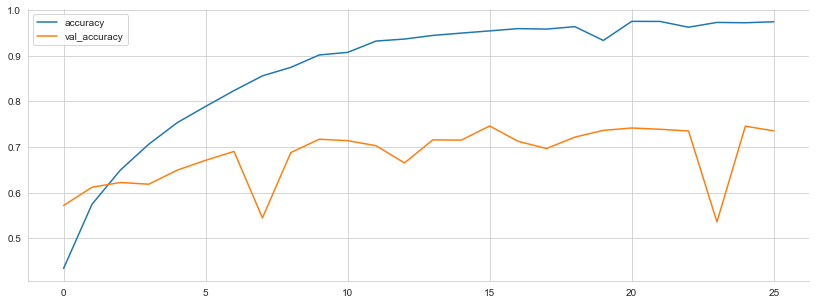

In [65]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine();

In [66]:
alexnet.load_weights(alexnet_path)

After training for 20 episodes, each of which takes a little under 30 seconds on a single GPU, we obtain 76.84% test accuracy.

In [67]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

Test Accuracy: 73.47%


## Compare Results

In [68]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })

In [69]:
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy
})

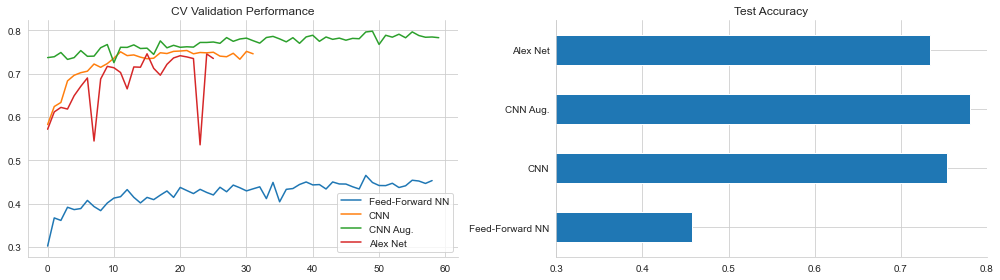

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);

## TensorBoard visualization

In [71]:
%load_ext tensorboard

In [72]:
%tensorboard --logdir results/cifar10/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-05-10 17:30:13.251407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
Traceback (most recent call last):
  File "c:\users\pc\anaconda3\envs\tensorflow_env\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\pc\anaconda3\envs\tensorflow_env\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\PC\anaconda3\envs\tensorflow_env\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\pc\anaconda3\envs\tensorflow_env\lib\site-packages\tensorboard\main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\pc\anaconda3\envs\tensorflow_env\lib\site-packages\absl\app.py", line 303, in run
    _run_main(main, args)
  File "c:\users\pc\anaconda3\envs\tensorflow_env\lib\site-packages\absl\app.